# COMPRESSION

La compression d'image est une application de la compression de données sur des images numériques. Cette compression a pour utilité de réduire la redondance des données d'une image afin de pouvoir l'emmagasiner sans occuper beaucoup d'espace ou la transmettre rapidement. 

Pour la compression JPEG, on prend une image qui est décomposée en blocs de 8x8 pixels. Une transformée en cosinus discrète (DCT) est réalisée sur chaque bloc. Les coefficients de la transformée sont ensuite quantifiés uniformément en association avec une matrice de dimension 8 sur 8 définissant les pas de quantification.

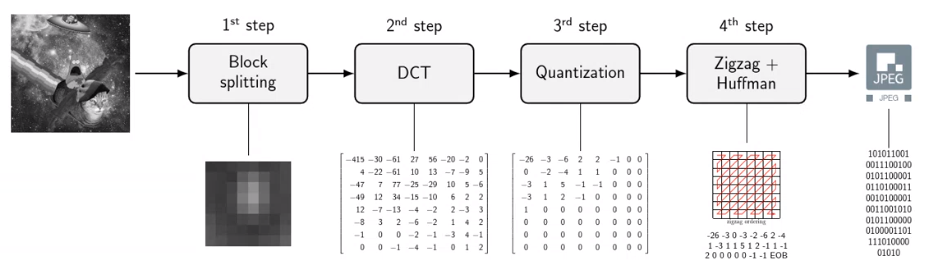

## IMPORTS

Il faut exécuter la command `pip install -r requirements.txt` afin d'installer toutes les librairies requises.

Vous trouverez ci-dessous les librairies que l'on doit importer.

In [51]:
import os
import imageio

import numpy as np
import itertools
import math

import decimal
import unittest

import random

import matplotlib.pylab as plt

## BLOCK SPLITTING

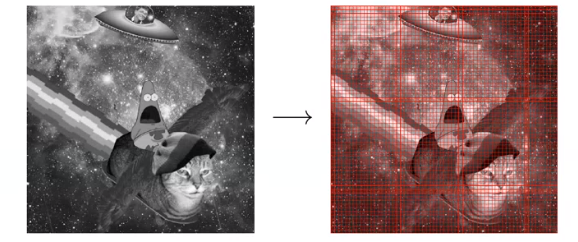

In [52]:
def get_dimensions(image):
    """
    `@params`: an image
    `@returns`: a tuple containing (height, width, depth=3)
    """
    return image.shape

La fonction `padding_8x8(image)` permet de recréer une nouvelle image avec les mêmes dimensions que l'image initiales mais arrondies (en excès) pour qu'elles soient des multiples de 8.

In [53]:
def padding_8x8(image):
    """
    `@params`: an image
    `@returns`: a new image (new height / new width, multiple of 8)
    """
    y, x, depth = get_dimensions(image)

    # Gets the missing width / height for it to be multiple of 8
    pad_height = (8 - (y % 8)) % 8
    pad_width = (8 - (x % 8)) % 8

    return np.pad(image, ((0, pad_height), (0, pad_width), (0, 0)), mode="edge")

La fonction `blocks_8x8(image)` permet de cnvertir notre image en une list de blocks de 8x8 pixels

In [54]:
def blocks_8x8_generator(image):
    height, width, _ = get_dimensions(image)

    # Loops over image as blocks of 8
    for y, x in itertools.product(range(0, height, 8), range(0, width, 8)):
        yield image[y:y+8, x:x+8]

In [55]:
def blocks_8x8(image):
    """
    `@params`: an image (height / width, multiple of 8)
    `@returns`: a list of 8 x 8 blocks
    """

    assert len(image) % 8 == 0
    assert len(image[0]) % 8 == 0

    # Generator -> list
    return list(blocks_8x8_generator(image))

## Transformée en cosinus discrète (DCT)

On va donc créer une matrice de coéfficient cosinus.

Le coût pour calculer la DCT sur un bloc se réduira à 2n multiplications sur des entiers, et 2n additions sur des entiers : cela représente un gain important par rapport à une simple double boucle sur les indices comme pourrait le laisser suggérer la formule initiale de la DCT. On passe d'un coût de O(n²) à un coût très intéressant de O(n) pour calculer UN bloc.

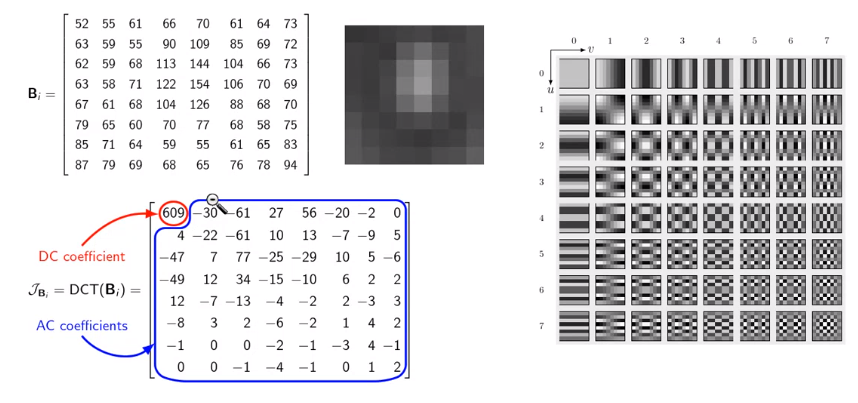

On crée ici la matrice de coefficient comme ci-dessous:

In [56]:
# Using the optimized _for numpy_ computations, we need to build DCT matrix
# from https://www-ljk.imag.fr/membres/Valerie.Perrier/SiteWeb/node9.html
DCT = np.zeros((8, 8))
for i, j in itertools.product(range(8), range(8)):
    if i == 0:
        DCT[i][j] = math.sqrt(2) / 2
    else:
        DCT[i][j] = math.cos(((2 * j + 1) * i * math.pi) / 16)
DCT = (1/2) * DCT


DCT_t = DCT.transpose()

In [57]:
def DCT_coeffs_8x8(image):
    # We have a list of color, len = 64
    # we need a 8x8 matrix to do the computations
    # so we convert it back and forth
    image = image.reshape((8, 8))
    res = np.dot(np.dot(DCT, image), DCT_t)
    return res.reshape(64)

## QUANTIFICATION

C’est l’étape à laquelle on applique un coefficient de perte qui annulera ou diminuera les valeurs des hautes fréquences. Les différentes composantes de la table DCT générée, pour chaque canal (intensité, bleu, rouge), seront arrondies à des valeurs plus petites (on fera une simple division entière + arrondi sur chaque valeur). Les valeurs qui contiennent le plus de détail par exemple celle tout en haut à gauche seront moins arrondies que les autres, et perdront moins de précision.

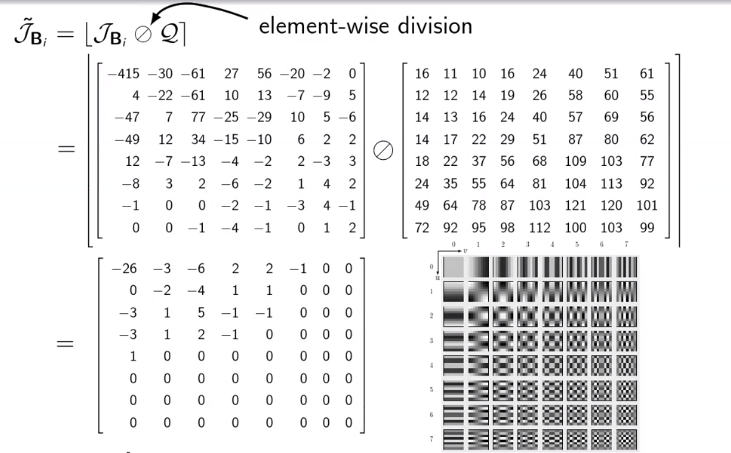

On crée ici la matrice de quantification.

In [58]:
JPEG_MATRIX_QUANTIFICATION = [16, 11, 10, 16, 24, 40, 51, 61,
                              12, 12, 14, 19, 26, 58, 60, 55,
                              14, 13, 16, 24, 40, 57, 69, 56,
                              14, 17, 22, 29, 51, 87, 80, 62,
                              18, 22, 37, 56, 68, 109, 103, 77,
                              24, 35, 55, 64, 81, 104, 113, 92,
                              49, 64, 78, 87, 703, 121, 120, 101,
                              72, 92, 95, 98, 112, 100, 103, 99]

# For future calculus
JPEG_MATRIX_QUANTIFICATION = np.array(JPEG_MATRIX_QUANTIFICATION)

On divise ainsi chaque bloc par notre matrice de quantification.

In [59]:
def quantization(dct):
    assert len(dct) == 64
    for i in range(64):
        dct[i] /= JPEG_MATRIX_QUANTIFICATION[i]

    return np.rint(dct).astype(np.int64)

## ZIGZAG

On parcourt chaque matrice quantifiée avec un parcours zigzag pour regrouper les zéros.

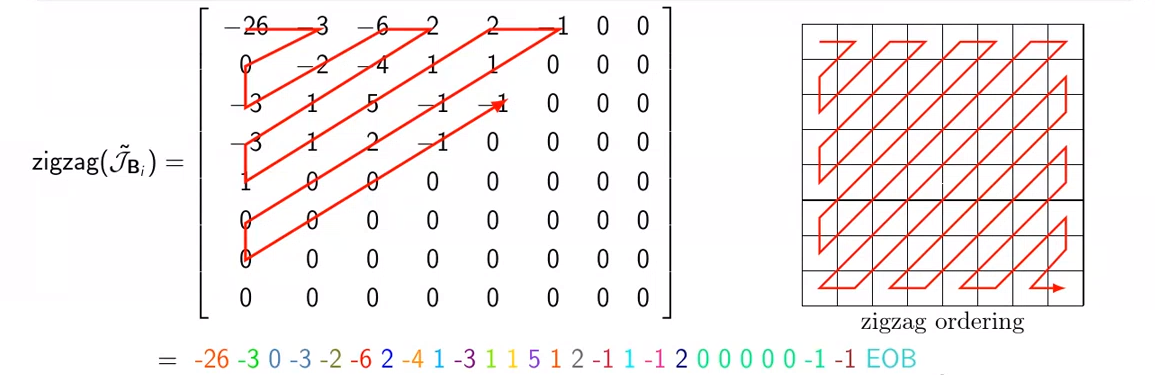

LA fonction `zigzag(quantized)` permet le parcours de nos matrices.

In [60]:
def zigzag_generator(input_qtz):
    solution = [[] for i in range(8 + 8 - 1)]

    for i in range(8):
        for j in range(8):
            sum = i + j
            if (sum % 2 == 0):
                solution[sum].insert(0, input_qtz[i * 8 + j])
            else:
                solution[sum].append(input_qtz[i * 8 + j])

    return [e for l in solution for e in l]

def zigzag(quantized):
    assert len(quantized) == 64
    l = list(zigzag_generator(quantized))
    while l[-1] == 0:
        del l[-1]
    return l

## HUFFMAN

Nous allons ensuite encoder les valeurs grâce aux tables d'Huffman. 

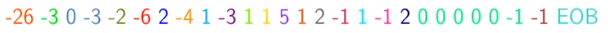

Voici le résulat après encodage. 

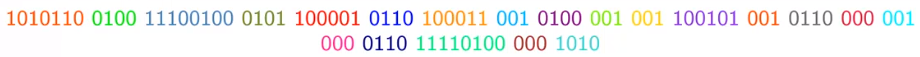

Nous introduisons les tables d'Huffman:

In [61]:
# All required tables for huffman

DCTable = [
    ("010", 3), ("011", 4), ("100", 5), ("00", 5),
    ("101", 7), ("110", 8), ("1110", 10),
    ("11110", 12), ("111110", 14), ("1111110", 16),
    ("11111110", 18), ("111111110", 20)
]

ACTable = [
    [  # 0/0 - 0/A
        ("1010", 4),
        ("00", 3),
        ("01", 4),
        ("100", 6),
        ("1011", 8),
        ("11010", 10),
        ("111000", 12),
        ("1111000", 14),
        ("1111110110", 18),
        ("1111111110000010", 25),
        ("1111111110000011", 26),
    ],
    [  # 1/1 - 1/A
        ("0", -1),
        ("1100", 5),
        ("111001", 8),
        ("1111001", 10),
        ("111110110", 13),
        ("11111110110", 16),
        ("1111111110000100", 22),
        ("1111111110000101", 23),
        ("1111111110000110", 24),
        ("1111111110000111", 25),
        ("1111111110001000", 26),
    ],
    [  # 2/1 - 2/A
        ("0", -1),
        ("11011", 6),
        ("11111000", 10),
        ("1111110111", 13),
        ("1111111110001001", 20),
        ("1111111110001010", 21),
        ("1111111110001011", 22),
        ("1111111110001100", 23),
        ("1111111110001101", 24),
        ("1111111110001110", 25),
        ("1111111110001111", 26),
    ],
    [  # 3/1 - 3/A
        ("0", -1),
        ("111010", 7),
        ("111110111", 11),
        ("11111110111", 14),
        ("1111111110010000", 20),
        ("1111111110010001", 21),
        ("1111111110010010", 22),
        ("1111111110010011", 23),
        ("1111111110010100", 24),
        ("1111111110010101", 25),
        ("1111111110010110", 26),
    ],
    [  # 4/1 - 4/A
        ("0", -1),
        ("111011", 7),
        ("1111111000", 12),
        ("1111111110010111", 19),
        ("1111111110011000", 20),
        ("1111111110011001", 21),
        ("1111111110011010", 22),
        ("1111111110011011", 23),
        ("1111111110011100", 24),
        ("1111111110011101", 25),
        ("1111111110011110", 26),
    ],
    [  # 5/1 - 5/A
        ("0", -1),
        ("1111010", 8),
        ("1111111001", 12),
        ("1111111110011111", 19),
        ("1111111110100000", 20),
        ("1111111110100001", 21),
        ("1111111110100010", 22),
        ("1111111110100011", 23),
        ("1111111110100100", 24),
        ("1111111110100101", 25),
        ("1111111110100110", 26),
    ],
    [  # 6/1 - 6/A
        ("0", -1),
        ("1111011", 8),
        ("11111111000", 13),
        ("1111111110100111", 19),
        ("1111111110101000", 20),
        ("1111111110101001", 21),
        ("1111111110101010", 22),
        ("1111111110101011", 23),
        ("1111111110101100", 24),
        ("1111111110101101", 25),
        ("1111111110101110", 26),
    ],
    [  # 7/1 - 7/A
        ("0", -1),
        ("11111001", 9),
        ("11111111001", 13),
        ("1111111110101111", 19),
        ("1111111110110000", 20),
        ("1111111110110001", 21),
        ("1111111110110010", 22),
        ("1111111110110011", 23),
        ("1111111110110100", 24),
        ("1111111110110101", 25),
        ("1111111110110110", 26),
    ],
    [  # 8/1 - 8/A
        ("0", -1),
        ("11111010", 9),
        ("111111111000000", 17),
        ("1111111110110111", 19),
        ("1111111110111000", 20),
        ("1111111110111001", 21),
        ("1111111110111010", 22),
        ("1111111110111011", 23),
        ("1111111110111100", 24),
        ("1111111110111101", 25),
        ("1111111110111110", 26),
    ],
    [  # 9/1 - 9/A
        ("0", -1),
        ("111111000", 10),
        ("1111111110111111", 18),
        ("1111111111000000", 19),
        ("1111111111000001", 20),
        ("1111111111000010", 21),
        ("1111111111000011", 22),
        ("1111111111000100", 23),
        ("1111111111000101", 24),
        ("1111111111000110", 25),
        ("1111111111000111", 26),
    ],
    [  # A/1 - A/A
        ("0", -1),
        ("111111001", 10),
        ("1111111111001000", 18),
        ("1111111111001001", 19),
        ("1111111111001010", 20),
        ("1111111111001011", 21),
        ("1111111111001100", 22),
        ("1111111111001101", 23),
        ("1111111111001110", 24),
        ("1111111111001111", 25),
        ("1111111111010000", 26),
    ],
    [  # B/1 - B/A
        ("0", -1),
        ("111111010", 10),
        ("1111111111010001", 18),
        ("1111111111010010", 19),
        ("1111111111010011", 20),
        ("1111111111010100", 21),
        ("1111111111010101", 22),
        ("1111111111010110", 23),
        ("1111111111010111", 24),
        ("1111111111011000", 25),
        ("1111111111011001", 26),
    ],
    [  # C/1 - C/A
        ("0", -1),
        ("1111111010", 11),
        ("1111111111011010", 18),
        ("1111111111011011", 19),
        ("1111111111011100", 20),
        ("1111111111011101", 21),
        ("1111111111011110", 22),
        ("1111111111011111", 23),
        ("1111111111100000", 24),
        ("1111111111100001", 25),
        ("1111111111100010", 26),
    ],
    [  # D/1 - D/A
        ("0", -1),
        ("11111111010", 12),
        ("1111111111100011", 18),
        ("1111111111100100", 19),
        ("1111111111100101", 20),
        ("1111111111100110", 21),
        ("1111111111100111", 22),
        ("1111111111101000", 23),
        ("1111111111101001", 24),
        ("1111111111101010", 25),
        ("1111111111101011", 26),
    ],
    [  # E/1 - E/A
        ("0", -1),
        ("111111110110", 13),
        ("1111111111101100", 18),
        ("1111111111101101", 19),
        ("1111111111101110", 20),
        ("1111111111101111", 21),
        ("1111111111110000", 22),
        ("1111111111110001", 23),
        ("1111111111110010", 24),
        ("1111111111110011", 25),
        ("1111111111110100", 26),
    ],
    [  # F/0 - F/A
        ("111111110111", 12),  # F/0 => 16 zeros d'affilés
        ("1111111111110101", 17),
        ("1111111111110110", 18),
        ("1111111111110111", 19),
        ("1111111111111000", 20),
        ("1111111111111001", 21),
        ("1111111111111010", 22),
        ("1111111111111011", 23),
        ("1111111111111100", 24),
        ("1111111111111101", 25),
        ("1111111111111110", 26),
    ]
]

Nous avions besoin d'un moyen rapide de décoder les données, un dictionnaire était assez simple pour nous.

Nous calculons l'inverse avant d'apporter des modifications architecturales aux tables initiales.

In [62]:
invACTable = dict()
for i, AC in enumerate(ACTable):
    for j, e in enumerate(AC):
        res = dict()
        res["run"] = i
        res["length"] = e[1]
        res["to_read"] = e[1] - len(e[0])
        res["cat"] = j
        if (i == 0 or i == 15) and j == 0:
            invACTable[e[0]] = res
        elif j == 0:
            continue

        invACTable[e[0]] = res


invDCTable = dict()
for i, DC in enumerate(DCTable):
    res = dict()
    res["length"] = DC[1]
    res["to_read"] = DC[1] - len(DC[0])
    res["cat"] = i
    invDCTable[DC[0]] = res


DCTable = [{"basecode": int(e[0], 2),
            "length": e[1],
            "shift": e[1] - len(e[0])} for e in DCTable]


for i, elem in enumerate(ACTable):
    tmp = [{"basecode": int(e[0], 2),
            "length": e[1],
            "shift": e[1] - len(e[0])} for e in elem]
    ACTable[i] = tmp

Les fonctions suivantes utilisent les tables réarangées pour encoder les valeurs DC/AC. 
+ DC: Premiere valeur.
+ AC: Toutes les autres valeurs.

In [63]:
def huffman_category(n):
    absN = abs(n)
    if absN <= 1:
        return absN

    inf, sup = 2, 4
    for i in range(1, 16):
        if absN >= inf and absN < sup:
            return i + 1
        inf, sup = sup, sup * 2


def huffman_number(n):
    if n >= 0:
        return n

    absN = -n
    inf, sup = 0, 1
    for i in range(-1, 16):
        if absN >= inf and absN < sup:
            break
        inf, sup = sup, sup * 2

    n += (sup - 1)
    return n


def huffman_DC_encoding(n):
    cat = huffman_category(n)
    vals = DCTable[cat]
    basecode, shift, length = vals["basecode"], vals["shift"], vals["length"]

    s = f"{basecode << shift | huffman_number(n):b}"
    s = ("0" * (length - len(s))) + s

    return s


def huffman_AC_encoding(n, zeros=0):
    cat = huffman_category(n)
    vals = ACTable[zeros][cat]
    basecode, shift, length = vals["basecode"], vals["shift"], vals["length"]

    s = f"{basecode << shift | huffman_number(n):b}"
    s = ("0" * (length - len(s))) + s

    return s

La fonction `parse_zigzag(zigzag)` appelle les fonctions d'encodage ci-dessus:

In [64]:
def parse_zigzag(zigzag):
    DC = huffman_DC_encoding(zigzag.pop(0))
    ACs = []

    while zigzag:
        zeros = 0
        while zigzag[0] == 0 and zeros < 15:
            zigzag.pop(0)
            zeros += 1
        ACs.append(huffman_AC_encoding(zigzag.pop(0), zeros))

    ACs.append("1010")

    ACs_ = " ".join(ACs)
    return f"{DC} {ACs_}"

## Les fonctions utilitaires

In [65]:
# From a string:
# e.g. "0110 1100" => 64+32+8+4 = 108 (string without space)
# This way we divide by 8 the content of the file, obviously

def string_to_bytes(s):
    bs = []
    for i in range(0, len(s), 8):
        tmp = 0
        for j in range(8):
            tmp += int(s[i + j]) * (2 ** (7 - j))
        bs.append(tmp)
    return bs

La fonction `extract_channel(image, channel_name)` récupère une des matrices associées aux couleurs RGB.

In [66]:
def extract_channel(image, channel_name):
    """
    `@params`: an image
    `@params`: channel name ('red', 'green' or 'blue')
    `@returns`: DCT for each image block
    """
    possibles = ['red', 'green', 'blue']
    if not channel_name in possibles:
        print(f"Channel name {channel_name} does not exist")
        exit(1)

    idx = possibles.index(channel_name)

    # Keeps first 2 dimensions (height / width)
    # In the 3rd (colors) keep only the one at idx
    img = image[:, :, idx]
    return img.flatten()

C'est la partie principale du programme.

Nous assemblons chaque bloc de code, en faisant les étapes précédentes pour chacun ainsi que ses trois couleurs.

In [67]:
# Global var repr. quality
q = 50

def compress(filename):
    image = imageio.imread(filename)
    image = image.astype(np.int16)
    
    plt.imshow(image), plt.axis('off'), plt.show()
    print("Dimensions:",image.shape)


    padded_img = padding_8x8(image)
    blocks = blocks_8x8(padded_img)
    colors = ["red", "green", "blue"]

    res = ""
    for b in blocks:
        for color in colors:
            cha = extract_channel(b, color)
            dct = DCT_coeffs_8x8(cha)
            qtz = quantization(dct)
            zzg = zigzag(qtz)
            out = parse_zigzag(zzg)
            res += out

    res = res.replace(" ", "")

    height, width, _ = get_dimensions(image)
    padded_zeros = (8 - (len(res) % 8)) % 8

    res += "0" * padded_zeros
    bytes_to_write = [height // 256, height % 256,
                      width // 256, width % 256,
                      padded_zeros, q]

    bytes_to_write = bytes(bytes_to_write + string_to_bytes(res))
    with open("out.ourjpg", "wb") as f:
        f.write(bytes_to_write)

## La fonction MAIN

La fonction `main(argv)` lance la compression en lui donnant comme liste d'arguments:
+ 1er argument: le nom du fichier à compresser
+ option "-q": permet de choisir la qualité de la compression (entre 5% et 95%)

In [68]:
def main(argv):
    global q
    global JPEG_MATRIX_QUANTIFICATION
    
    if "-q" in argv:
        q_idx = argv.index("-q")
        try:
            q = int(argv[q_idx + 1])
        except:
            print("Wrong usage of -q: ./compress.py file -q <value>")

    if q != 50:
        if q > 50:
            alpha = 200 - 2 * q
        else:
            alpha = 5000 / q
        JPEG_MATRIX_QUANTIFICATION = (
            (alpha * JPEG_MATRIX_QUANTIFICATION) + 50) / 100

    if len(argv):
        compress(argv[0])
    else:
        compress("assets/256.jpg")

Un fichier "out.ourjpg" a été créé, utilisez le cahier de décompression pour voir comment ça s'est passé.

L'image que nous utilisons est la suivante :

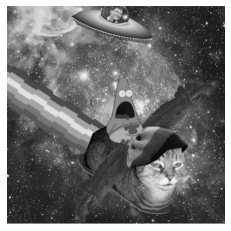

Dimensions: (567, 567, 3)


In [69]:
main(["assets/nyancat-patrick.png", "-q", "25"])